In [5]:
import pandas as pd
import numpy as np

from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error


In [6]:
data = pd.read_csv('PriceStats_CPI.csv')
data

,date,PriceStats,CPI
0,2008-07-24,100.00000,100.0
1,2008-07-25,99.99767,100.0
2,2008-07-26,99.92376,100.0
3,2008-07-27,99.91537,100.0
4,2008-07-28,99.89491,100.0
...,...,...,...
3727,2018-10-07,116.57270,NaN
3728,2018-10-08,116.57920,NaN
3729,2018-10-09,116.58820,NaN
3730,2018-10-10,116.59060,NaN


New best order: 1 (MSE: 8.237064689436477e-06
New best order: 2 (MSE: 6.3508968048341465e-06
New best order: 3 (MSE: 5.69317882331669e-06
New best order: 4 (MSE: 5.661315855981922e-06
Best order: 4


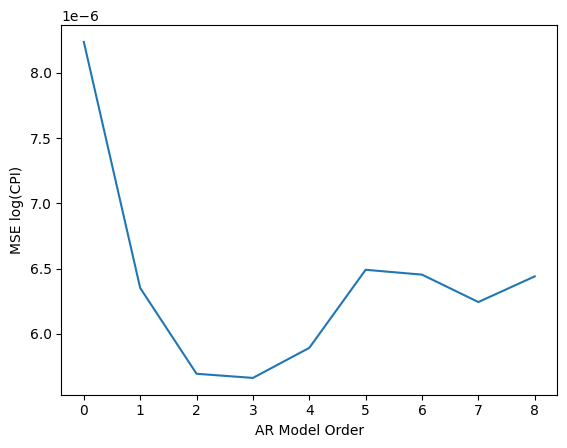

In [7]:
# Load the data
data = pd.read_csv('PriceStats_CPI.csv')

# Use the first CPI value of each month as that month's CPI
data['date'] = pd.to_datetime(data['date'])
data = data.groupby(pd.Grouper(key='date', freq='MS')).first()

# Work in log scale
data['CPI_log'] = np.log(data['CPI'])

# Drop any rows with NaN values
data = data.dropna()

train_data = data.loc[data.index < '2013-09-01', 'CPI_log']
test_data = data.loc[data.index >= '2013-09-01', 'CPI_log']

best_order = 0
min_mse = float('inf')
mse_list = []
preds = []
best_model = None
for order in range(1, 10):  # Test AR models of orders 1-12
    model = AutoReg(train_data, lags=order)
    model_fit = model.fit()
    pred = AutoReg(data['CPI_log'], lags = order, old_names=False)
    
    # predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
    
    predictions = pred.predict(model_fit.params, start=len(train_data), end=len(data)-1)

    mse = mean_squared_error(test_data, predictions)
    mse_list.append(mse)
    if mse < min_mse:
        min_mse = mse
        best_order = order

        best_model = model_fit
        preds = predictions
        print(f"New best order: {order} (MSE: {mse}")

print(f"Best order: {best_order}")
plt.xlabel('AR Model Order')
plt.ylabel('MSE log(CPI)')
plt.plot(range(0, 9), mse_list)


In [8]:
data.head()

,PriceStats,CPI,CPI_log
date,,,
2008-07-01,100.00000,100.00000,4.605170
2008-08-01,99.85761,100.52510,4.610407
2008-09-01,99.65436,100.12380,4.606407
2008-10-01,99.72428,99.98538,4.605024
2008-11-01,97.99059,98.97539,4.594871


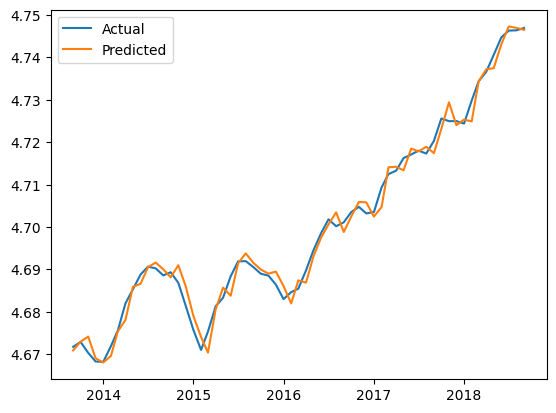

In [9]:
# plot the predictions
plt.plot(test_data.index, test_data, label='Actual')
plt.plot(test_data.index, preds, label='Predicted')
plt.legend()

In [10]:
# Load the BER data
ber_5_year = pd.read_csv('T5YIE.csv')
ber_10_year = pd.read_csv('T10YIE.csv')

# Convert the date columns to datetime objects
ber_5_year['DATE'] = pd.to_datetime(ber_5_year['DATE'])
ber_10_year['DATE'] = pd.to_datetime(ber_10_year['DATE'])
ber_5_year['T5YIE'] = pd.to_numeric(ber_5_year['T5YIE'], errors='coerce')
ber_10_year['T10YIE'] = pd.to_numeric(ber_10_year['T10YIE'], errors='coerce')
# Group the daily PriceStats data by month and take the first value of each month
data['PriceStats_monthly'] = data['PriceStats']

# Calculate the monthly inflation rate from the CPI data and the 1-month ahead predictions
data['CPI_inflation_rate'] = data['CPI'].pct_change()
data['predicted_CPI'] = np.exp(preds)  # Convert back from log scale
data['predicted_inflation_rate'] = data['predicted_CPI'].pct_change()

# Calculate the monthly inflation rate from the PriceStats data
data['PriceStats_inflation_rate'] = data['PriceStats_monthly'].pct_change()

# Calculate the average BER value for each month
ber_5_year_monthly = ber_5_year.groupby(pd.Grouper(key='DATE', freq='MS'))['T5YIE'].mean().to_frame().reset_index()

# take the monthly average of the 5-year BER

# Calculate the average BER value for each month
ber_10_year_monthly = ber_10_year.groupby(pd.Grouper(key='DATE', freq='MS'))['T10YIE'].mean().to_frame().reset_index()


In [11]:
data.head()

,PriceStats,CPI,CPI_log,PriceStats_monthly,CPI_inflation_rate,predicted_CPI,predicted_inflation_rate,PriceStats_inflation_rate
date,,,,,,,,
2008-07-01,100.00000,100.00000,4.605170,100.00000,NaN,NaN,NaN,NaN
2008-08-01,99.85761,100.52510,4.610407,99.85761,0.005251,NaN,NaN,-0.001424
2008-09-01,99.65436,100.12380,4.606407,99.65436,-0.003992,NaN,NaN,-0.002035
2008-10-01,99.72428,99.98538,4.605024,99.72428,-0.001382,NaN,NaN,0.000702
2008-11-01,97.99059,98.97539,4.594871,97.99059,-0.010101,NaN,NaN,-0.017385


In [12]:
# Merge the BER data with the existing data
data = data.merge(ber_5_year_monthly, left_on='date', right_on='DATE', how='left').merge(ber_10_year_monthly, left_on='DATE', right_on='DATE', how='left')


In [13]:
data

,PriceStats,CPI,CPI_log,PriceStats_monthly,CPI_inflation_rate,predicted_CPI,predicted_inflation_rate,PriceStats_inflation_rate,DATE,T5YIE,T10YIE
0,100.00000,100.00000,4.605170,100.00000,NaN,NaN,NaN,NaN,2008-07-01,2.462727,2.438636
1,99.85761,100.52510,4.610407,99.85761,0.005251,NaN,NaN,-0.001424,2008-08-01,1.993810,2.209524
2,99.65436,100.12380,4.606407,99.65436,-0.003992,NaN,NaN,-0.002035,2008-09-01,1.330952,1.836190
3,99.72428,99.98538,4.605024,99.72428,-0.001382,NaN,NaN,0.000702,2008-10-01,-0.027727,1.061818
4,97.99059,98.97539,4.594871,97.99059,-0.010101,NaN,NaN,-0.017385,2008-11-01,-1.398889,0.638333
...,...,...,...,...,...,...,...,...,...,...,...
118,115.39380,114.50130,4.740586,115.39380,0.003975,114.143607,0.000243,0.004701,2018-05-01,2.101818,2.141818
119,115.83110,114.97750,4.744736,115.83110,0.004159,114.788421,0.005649,0.003790,2018-06-01,2.067619,2.117619
120,115.86930,115.16080,4.746329,115.86930,0.001594,115.273082,0.004222,0.000330,2018-07-01,2.042381,2.114286
121,116.09710,115.16850,4.746396,116.09710,0.000067,115.235785,-0.000324,0.001966,2018-08-01,1.982609,2.099130


In [14]:
# Convert the annual inflation rate to a monthly rate for the BER data
data['BER_5_year_monthly_rate'] = (1 + data['T5YIE'])**(1/120) - 1
data['BER_10_year_monthly_rate'] = (1 + data['T10YIE'])**(1/120) - 1

# Print the results
print(data[['DATE', 'CPI_inflation_rate', 'predicted_inflation_rate', 'PriceStats_inflation_rate', 'BER_5_year_monthly_rate', 'BER_10_year_monthly_rate']].tail())


          DATE  CPI_inflation_rate  predicted_inflation_rate   
118 2018-05-01            0.003975                  0.000243  \
119 2018-06-01            0.004159                  0.005649   
120 2018-07-01            0.001594                  0.004222   
121 2018-08-01            0.000067                 -0.000324   
122 2018-09-01            0.000556                 -0.000473   

     PriceStats_inflation_rate  BER_5_year_monthly_rate   
118                   0.004701                 0.009478  \
119                   0.003790                 0.009385   
120                   0.000330                 0.009315   
121                   0.001966                 0.009148   
122                   0.000236                 0.009221   

     BER_10_year_monthly_rate  
118                  0.009586  
119                  0.009521  
120                  0.009512  
121                  0.009471  
122                  0.009536  


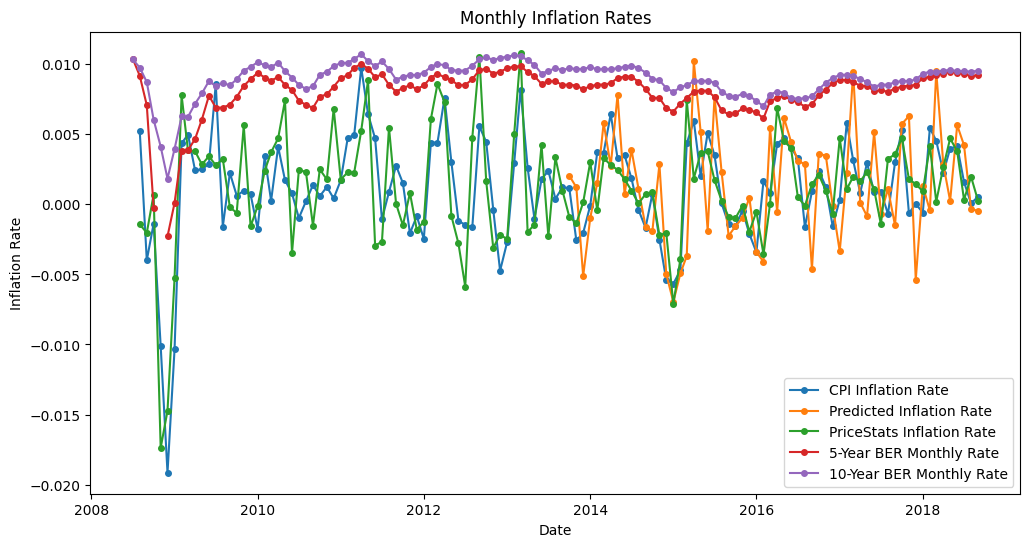

In [15]:
import matplotlib.pyplot as plt

# Set the date column as the index for easier plotting
data.set_index('DATE', inplace=True)

# Plot the inflation rates
plt.figure(figsize=(12, 6))
plt.plot(data['CPI_inflation_rate'], label='CPI Inflation Rate', linestyle='-', marker='o', markersize=4)
plt.plot(data['predicted_inflation_rate'], label='Predicted Inflation Rate', linestyle='-', marker='o', markersize=4)
plt.plot(data['PriceStats_inflation_rate'], label='PriceStats Inflation Rate', linestyle='-', marker='o', markersize=4)
plt.plot(data['BER_5_year_monthly_rate'], label='5-Year BER Monthly Rate', linestyle='-', marker='o', markersize=4)
plt.plot(data['BER_10_year_monthly_rate'], label='10-Year BER Monthly Rate', linestyle='-', marker='o', markersize=4)

# Set the title, labels, and legend
plt.title('Monthly Inflation Rates')
plt.xlabel('Date')
plt.ylabel('Inflation Rate')
plt.legend()

# Display the plot
plt.show()


In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prepare external regressors
data['PriceStats_log'] = np.log(data['PriceStats_monthly'])
data['BER_5_year_monthly_log'] = np.log(data['BER_5_year_monthly_rate'])
data['BER_10_year_monthly_log'] = np.log(data['BER_10_year_monthly_rate'])


/Users/merlimar/miniconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [17]:

train_data_ext = data.loc[data.index < '2013-09-01', ['PriceStats_log', 'BER_5_year_monthly_log', 'BER_10_year_monthly_log']]
test_data_ext = data.loc[data.index >= '2013-09-01', ['PriceStats_log', 'BER_5_year_monthly_log', 'BER_10_year_monthly_log']]
# Fill missing values with the mean of the respective column
train_data_ext.fillna(train_data_ext.mean(), inplace=True)
test_data_ext.fillna(test_data_ext.mean(), inplace=True)


In [18]:
test_data_ext2 = data.loc[data.index >= '2013-09-01', ['PriceStats_log', 'BER_5_year_monthly_log', 'BER_10_year_monthly_log']]
test_data_ext2 = data.loc[data.index >= '2013-09-01', ['PriceStats_log', 'BER_5_year_monthly_log', 'BER_10_year_monthly_log']]

In [19]:
train_data_ext.head()

,PriceStats_log,BER_5_year_monthly_log,BER_10_year_monthly_log
DATE,,,
2008-07-01,4.605170,-4.565544,-4.571209
2008-08-01,4.603745,-4.690753,-4.628945
2008-09-01,4.601708,-4.950872,-4.741560
2008-10-01,4.602409,-4.871074,-5.108008
2008-11-01,4.584871,-4.871074,-5.491303


In [20]:
# find nan values in train_data_ext
train_data_ext.isnull().sum()

PriceStats_log             0
BER_5_year_monthly_log     0
BER_10_year_monthly_log    0
dtype: int64

In [ ]:

# Fit the SARIMAX models
sarimax_average = SARIMAX(train_data, exog=train_data_ext, order=(best_order, 0, 0)).fit()
sarimax_first_day = SARIMAX(train_data, exog=train_data_ext, order=(best_order, 0, 0)).fit()


In [ ]:

# Calculate prediction errors
pred_average = sarimax_average.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, exog=test_data_ext)
pred_first_day = sarimax_first_day.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, exog=test_data_ext)

mse_average = mean_squared_error(test_data, pred_average)
mse_first_day = mean_squared_error(test_data, pred_first_day)

print(f"Prediction error using monthly average PriceStats and BER data: {mse_average}")
print(f"Prediction error using first day of each month PriceStats and BER data: {mse_first_day}")

# plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(test_data, label='Actual Inflation Rate', linestyle='-', marker='o', markersize=4)
plt.plot(pred_average, label='Predicted Inflation Rate (Average)', linestyle='-', marker='o', markersize=4)
plt.plot(pred_first_day, label='Predicted Inflation Rate (First Day)', linestyle='-', marker='o', markersize=4)
plt.legend()

# START HERE

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('PriceStats_CPI.csv')

# Use the first CPI value of each month as that month's CPI
data['date'] = pd.to_datetime(data['date'])
data = data.groupby(pd.Grouper(key='date', freq='MS')).first()

# Work in log scale
data['CPI_log'] = np.log(data['CPI'])

# Drop any rows with NaN values
data = data.dropna()

train_data = data.loc[data.index < '2013-09-01', 'CPI_log']
test_data = data.loc[data.index >= '2013-09-01', 'CPI_log']

best_order = 0
min_mse = float('inf')
mse_list = []
preds = []
best_model = None
for order in range(1, 13):  # Test AR models of orders 1-12
    model = AutoReg(train_data, lags=order)
    model_fit = model.fit()
    pred = AutoReg(data['CPI_log'], lags=order, old_names=False)
    
    predictions = pred.predict(model_fit.params, start=len(train_data), end=len(data)-1)

    mse = mean_squared_error(test_data, predictions)
    mse_list.append(mse)
    if mse < min_mse:
        min_mse = mse
        best_order = order

        best_model = model_fit
        preds = predictions
        print(f"New best order: {order} (MSE: {mse})")

print(f"Best order: {best_order}")
plt.xlabel('AR Model Order')
plt.ylabel('MSE log(CPI)')
plt.plot(range(1, 13), mse_list)
plt.show()


In [ ]:
# Calculate the percentage change in the CPI data
data['CPI_inflation'] = data['CPI'].pct_change()
data['CPI_inflation'] = data['CPI_inflation'] * 100

# Calculate the percentage change in the 1-month ahead predictions
preds_exp = np.exp(preds)  # Convert log scale predictions back to original scale
preds_series = pd.Series(preds_exp, index=test_data.index)
preds_inflation = preds_series.pct_change()
preds_inflation = preds_inflation * 100


In [ ]:
data['PriceStats_inflation'] = data['PriceStats'].pct_change()
data['PriceStats_inflation'] = data['PriceStats_inflation'] * 100


In [ ]:
# Load BER data
ber_5yr = pd.read_csv('T5YIE.csv')
ber_10yr = pd.read_csv('T10YIE.csv')

ber_5yr['T5YIE'] = pd.to_numeric(ber_5yr['T5YIE'], errors='coerce')
ber_10yr['T10YIE'] = pd.to_numeric(ber_10yr['T10YIE'], errors='coerce')
# Convert the date columns to datetime objects
ber_5yr['DATE'] = pd.to_datetime(ber_5yr['DATE'])
ber_10yr['DATE'] = pd.to_datetime(ber_10yr['DATE'])

# Set the index to the date column
ber_5yr.set_index('DATE', inplace=True)
ber_10yr.set_index('DATE', inplace=True)


# data['BER_5_year_monthly_rate'] = (1 + data['T5YIE'])**(1/120) - 1
# data['BER_10_year_monthly_rate'] = (1 + data['T10YIE'])**(1/120) - 1

# Calculate monthly inflation rates from BER data
ber_5yr['monthly_inflation'] = ((1 + ber_5yr['T5YIE'])**(1/120) - 1) * 100
ber_10yr['monthly_inflation'] = ((1 + ber_10yr['T10YIE'])**(1/120) - 1) * 100


In [ ]:
# Define the start date for the plot
plot_start_date = '2013-09-01'

plt.figure(figsize=(10, 6))
plt.plot(data.loc[data.index >= plot_start_date].index, data.loc[data.index >= plot_start_date, 'CPI_inflation'], label='CPI')
plt.plot(preds_inflation.index, preds_inflation, label='AR Predictions')
plt.plot(data.loc[data.index >= plot_start_date].index, data.loc[data.index >= plot_start_date, 'PriceStats_inflation'], label='PriceStats')
plt.plot(ber_5yr.loc[ber_5yr.index >= plot_start_date].index, ber_5yr.loc[ber_5yr.index >= plot_start_date, 'monthly_inflation'], label='5-Year BER')
plt.plot(ber_10yr.loc[ber_10yr.index >= plot_start_date].index, ber_10yr.loc[ber_10yr.index >= plot_start_date, 'monthly_inflation'], label='10-Year BER')
plt.xlabel('Date')
plt.ylabel('Monthly Inflation Rate')
plt.title('Monthly Inflation Rates from Different Data Sources (Starting September 2013)')
plt.legend()
plt.show()


# Part C

New best order: 1 (MSE: 8.237064689436477e-06)
New best order: 2 (MSE: 6.3508968048341465e-06)
New best order: 3 (MSE: 5.69317882331669e-06)
New best order: 4 (MSE: 5.661315855981922e-06)
Best order: 4


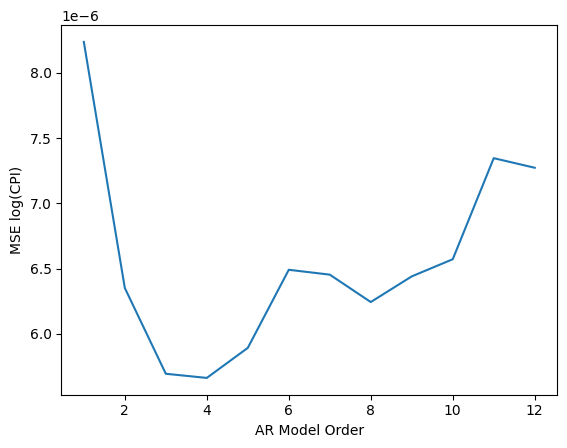

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('PriceStats_CPI.csv')

# Use the first CPI value of each month as that month's CPI
data['date'] = pd.to_datetime(data['date'])
data = data.groupby(pd.Grouper(key='date', freq='MS')).first()

# Work in log scale
data['CPI_log'] = np.log(data['CPI'])
data['PriceStats_log'] = np.log(data['PriceStats'])

# Drop any rows with NaN values
data = data.dropna()

train_data = data.loc[data.index < '2013-09-01', 'CPI_log']
test_data = data.loc[data.index >= '2013-09-01', 'CPI_log']

best_order = 0
min_mse = float('inf')
mse_list = []
preds = []
best_model = None
for order in range(1, 13):  # Test AR models of orders 1-12
    model = AutoReg(train_data, lags=order)
    model_fit = model.fit()
    pred = AutoReg(data['CPI_log'], lags=order, old_names=False)
    
    predictions = pred.predict(model_fit.params, start=len(train_data), end=len(data)-1)

    mse = mean_squared_error(test_data, predictions)
    mse_list.append(mse)
    if mse < min_mse:
        min_mse = mse
        best_order = order

        best_model = model_fit
        preds = predictions
        print(f"New best order: {order} (MSE: {mse})")

print(f"Best order: {best_order}")
plt.xlabel('AR Model Order')
plt.ylabel('MSE log(CPI)')
plt.plot(range(1, 13), mse_list)
plt.show()


In [2]:
# Calculate the percentage change in the CPI data
data['CPI_inflation'] = data['CPI_log'].pct_change()
data['CPI_inflation'] = data['CPI_inflation'] * 100

# Calculate the percentage change in the 1-month ahead predictions
preds_exp = preds  # Convert log scale predictions back to original scale
preds_series = pd.Series(preds_exp, index=test_data.index)
preds_inflation = preds_series.pct_change()
preds_inflation = preds_inflation * 100



In [3]:
data['PriceStats_inflation'] = data['PriceStats_log'].pct_change()
data['PriceStats_inflation'] = data['PriceStats_inflation'] * 100


In [4]:
#graph of CPI and PriceStats log pc
plt.figure(figsize=(10, 6))
plt.plot(data.loc[data.index >= plot_start_date].index, data.loc[data.index >= plot_start_date, 'CPI_log'], label='CPI')
plt.plot(preds.index, preds, label='AR Predictions')
plt.xlabel('Date')
plt.ylabel('Log(CPI)')
plt.title('Log(CPI) from Different Data Sources (Starting September 2013)')
plt.legend()

NameError: name 'plot_start_date' is not defined

<Figure size 1000x600 with 0 Axes>

In [485]:
monthly_average_data

,PriceStats,T5YIE,T10YIE
2003-01-01,NaN,1.398095,1.754286
2003-02-01,NaN,1.654211,1.912632
2003-03-01,NaN,1.695238,1.862857
2003-04-01,NaN,1.568571,1.774762
2003-05-01,NaN,1.336667,1.660952
...,...,...,...
2018-07-01,115.8693,2.042381,2.114286
2018-08-01,116.0971,1.982609,2.099130
2018-09-01,116.1245,2.008421,2.123158
2018-10-01,NaN,1.987273,2.111364


In [ ]:
 # Calculate the monthly average of PriceStats and BER data
monthly_average_price_stats = data['PriceStats'].resample('MS').mean()
monthly_average_ber_5yr = ber_5yr['T5YIE'].resample('MS').mean()
monthly_average_ber_10yr = ber_10yr['T10YIE'].resample('MS').mean()

# Merge the data
monthly_average_data = pd.concat([monthly_average_price_stats, monthly_average_ber_5yr, monthly_average_ber_10yr], axis=1)
monthly_average_data.columns = ['PriceStats', 'T5YIE', 'T10YIE']
monthly_average_data = monthly_average_data.dropna()

# Use the first day of each month for PriceStats and BER data
first_day_data = data[['PriceStats', 'CPI']].merge(ber_5yr[['T5YIE']], left_index=True, right_index=True, how='inner').merge(ber_10yr[['T10YIE']], left_index=True, right_index=True, how='inner')


In [ ]:
monthly_average_data
monthly_average_data = monthly_average_data.loc[data.index >= '2013-09-01']


In [ ]:
# print the length of each data
print(len(data))
print(len(monthly_average_data))
print(len(monthly_average_data))

first_day_data